<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Parking_spot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classifier

We buid a modelto predict the parking spots, if they are empty or not.

[Data](https://drive.google.com/file/d/11DyZ165lZGzULEZSQNofyy9A8xaYgFJ2)

In [ ]:
import os
import cv2
import pickle
import shutil
import sklearn
import skimage
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn import metrics
from sklearn import model_selection

In [ ]:
zip_folder = '/content/drive/MyDrive/DATA/car-parking-slot-empty-notempty.zip'
shutil.copyfile(zip_folder, '/content/data.zip')
!unzip \*.zip && rm *.zip

In [ ]:
data = []
labels = []
for id, cat in enumerate(['empty', 'not_empty']):
  path = f'./clf-data/{cat}/'
  for img in os.listdir(path):
    img = skimage.io.imread(path+img)
    img = skimage.transform.resize(img, (15, 15))
    data.append(img.flatten())
    labels.append(id)

data = np.asarray(data)
labels = np.asarray(labels)

data.shape,labels.shape

((6090, 675), (6090,))

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=32)
x_train.shape, x_test.shape

In [ ]:
clf = svm.SVC()

parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = model_selection.GridSearchCV(clf, parameters)

In [ ]:
# grid_search.fit(x_train, y_train)

# # test performance
# best_estimator = grid_search.best_estimator_

# y_prediction = best_estimator.predict(x_test)

# score = metrics.accuracy_score(y_prediction, y_test)

# print('{}% of samples were correctly classified'.format(str(score * 100)))

# pickle.dump(best_estimator, open('./model.p', 'wb'))

100.0% of samples were correctly classified


#Parking Spot Detector

In [ ]:
MODEL = pickle.load(open("./drive/MyDrive/DATA/model.p", "rb"))

In [ ]:
def empty_or_not(spot_bgr):

    img_resized = skimage.transform.resize(spot_bgr, (15, 15, 3))
    pred = MODEL.predict(np.array([img_resized.flatten()]))
    return True if pred == 0 else False

In [ ]:
def get_parking_spots_bboxes(connected_components, coef=1):
    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots

In [ ]:
calc_diff = lambda im1, im2: np.abs(np.mean(im1) - np.mean(im2))

In [ ]:
mask = './mask_1920_1080.png'
video_path = './samples/parking_1920_1080_loop.mp4'


mask = cv2.imread(mask, 0)

cap = cv2.VideoCapture(video_path)

connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

spots = get_parking_spots_bboxes(connected_components)

spots_status = [None for j in spots]
diffs = [None for j in spots]

previous_frame = None

frame_nmr = 0
ret = True
step = 30
while ret:
    ret, frame = cap.read()

    if frame_nmr % step == 0 and previous_frame is not None:
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

        print([diffs[j] for j in np.argsort(diffs)][::-1])

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]
        for spot_indx in arr_:
            spot = spots[spot_indx]
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            spot_status = empty_or_not(spot_crop)

            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]

        if spot_status:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
        else:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), 2)

    cv2.rectangle(frame, (80, 20), (550, 80), (0, 0, 0), -1)
    cv2.putText(frame, 'Available spots: {} / {}'.format(str(sum(spots_status)), str(len(spots_status))), (100, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()

#New
[pklotsdbs](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset)

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection
from IPython.display import clear_output

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d blanderbuss/parking-lot-dataset
!unzip \*.zip && rm *.zip
clear_output()

#Classification

In [3]:
cls_data = './PKLot/PKLotSegmented'
train_path = './data/train'
val_path   = './data/validation'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

VAL_THRESHOLD = 0.2
data_arr = []

In [8]:
for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O):
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)

data = pd.DataFrame(data_arr, columns=['path', 'label'])
data.head()

,path,label
0,./PKLot/PKLotSegmented/train/2013-03-10_14_00_...,0
1,./PKLot/PKLotSegmented/validation/2013-03-10_1...,0
2,./PKLot/PKLotSegmented/train/2013-03-10_14_20_...,0
3,./PKLot/PKLotSegmented/validation/2013-03-10_1...,0
4,./PKLot/PKLotSegmented/train/2013-03-10_07_15_...,0


In [ ]:
data.groupby(['label']).count()

,path
label,
0,358071
1,337780


In [9]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory('./data',
                                                               validation_split=0.2,
                                                               subset='both',
                                                               seed=32,
                                                               image_size=(250, 250),
                                                               batch_size=32)

Found 695805 files belonging to 2 classes.
Using 556644 files for training.
Using 139161 files for validation.


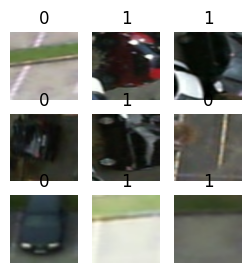

In [12]:
plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# x_train, x_test, y_train, y_test = model_selection.train_test_split(data.path.values, data.label.values, test_size=0.2, random_state=32)
# x_train.shape, x_test.shape

((556680,), (139171,))

In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
	'/content/Empty/',
	labels="inferred",
	label_mode="int",
	class_names=None,
	color_mode="rgb",
	batch_size=32,
	image_size=(256, 256),
	shuffle=True,
	seed=32,
	validation_split=None,
	subset=None,
	interpolation="bilinear",
	follow_links=False,
	crop_to_aspect_ratio=False,
)